# Cost function tutorial

This is a topical tutorial. If you are new to iminuit, you should go through the basic tutorial first. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing.pool import Pool

In [4]:
n_tries = 100
n_pts = np.array((10, 30, 100, 300, 1000, 3000, 10000))

def compute(n):
    from iminuit import Minuit
    from iminuit.cost import UnbinnedNLL, BinnedNLL, ExtendedUnbinnedNLL, ExtendedBinnedNLL
    import numba as nb
    import math

    kwd = {"parallel": True, "fastmath": True}

    @nb.njit(**kwd)
    def norm_pdf(x, mu, sigma):
        invs = 1.0 / sigma
        z = (x - mu) * invs
        invnorm = 1 / np.sqrt(2 * np.pi) * invs
        return np.exp(-0.5 * z**2) * invnorm


    @nb.njit(**kwd)
    def nb_erf(x):
        y = np.empty_like(x)
        for i in nb.prange(len(x)):
            y[i] = math.erf(x[i])
        return y


    @nb.njit(**kwd)
    def norm_cdf(x, mu, sigma):
        invs = 1.0 / (sigma * np.sqrt(2))
        z = (x - mu) * invs
        return 0.5 * (1 + nb_erf(z))


    @nb.njit
    def norm_delta(xrange, mu, sigma):
        c = norm_cdf(xrange, mu, sigma)
        return c[1] - c[0]
    
    np.random.seed(n)
    u_nll = []
    b_nll = []
    e_u_nll = []
    e_b_nll = []
    for i_try in range(n_tries):
        while True:
            x = np.random.randn(2 * n)
            x = x[np.abs(x) < 2]
            x = x[:n]
            xrange = np.array((-2.0, 2.0))
            nh, xe = np.histogram(x, bins=n//2, range=xrange)            
            m = [
                Minuit(UnbinnedNLL(x, lambda x, mu, sigma: (norm_pdf(x, mu, sigma) / norm_delta(xrange, mu, sigma))),
                       mu=0, sigma=1,
                       limit_sigma=(0, None)),
                Minuit(ExtendedUnbinnedNLL(x, lambda x, n, mu, sigma: (n * norm_delta(xrange, mu, sigma), n * norm_pdf(x, mu, sigma))),
                       n=n, mu=0, sigma=1,
                       limit_sigma=(0, None),
                       limit_n=(0, None)),
                Minuit(BinnedNLL(nh, xe, lambda x, mu, sigma: (norm_cdf(x, mu, sigma) / norm_delta(xrange, mu, sigma))),
                       mu=0, sigma=1,
                       limit_sigma=(1e-3, None)),
                Minuit(ExtendedBinnedNLL(nh, xe, lambda x, n, mu, sigma: n * norm_cdf(x, mu, sigma)),
                       n=n, mu=0, sigma=1,
                       limit_sigma=(0, None),
                       limit_n=(0, None))
            ]
            
            all_good = True
            for mi in m:
                mi.migrad()
                mi.hesse()
                if not mi.valid or not mi.accurate:
                    all_good = False
                    break
            if all_good:
                break
            print(f"{n} {i_try} need to re-try {[(mi.valid, mi.accurate) for mi in m]}")

        u_nll.append((m[0].values["mu"], m[0].errors["mu"] ** 2,
                      m[0].values["sigma"], m[0].errors["sigma"] ** 2))
        e_u_nll.append((m[1].values["n"], m[1].errors["n"] ** 2,
                        m[1].values["mu"], m[1].errors["mu"] ** 2,
                        m[1].values["sigma"], m[1].errors["sigma"] ** 2))
        b_nll.append((m[2].values["mu"], m[2].errors["mu"] ** 2,
                      m[2].values["sigma"], m[2].errors["sigma"] ** 2))
        e_b_nll.append((m[3].values["n"], m[3].errors["n"] ** 2,
                        m[3].values["mu"], m[3].errors["mu"] ** 2,
                        m[3].values["sigma"], m[3].errors["sigma"] ** 2))
    return np.mean(u_nll, axis=0), np.mean(e_u_nll, axis=0), np.mean(b_nll, axis=0), np.mean(e_b_nll, axis=0)

unbinned_nll = []
extended_unbinned_nll = []
binned_nll = []
extended_binned_nll = []

with Pool() as p:
    for u, eu, b, eb in p.map(compute, n_pts):
        unbinned_nll.append(u)
        extended_unbinned_nll.append(eu)
        binned_nll.append(b)
        extended_binned_nll.append(eb)
        
unbinned_nll = np.transpose(unbinned_nll)
extended_unbinned_nll = np.transpose(extended_unbinned_nll)
binned_nll = np.transpose(binned_nll)
extended_binned_nll = np.transpose(extended_binned_nll)

10 43 need to re-try [(True, True), (True, True), (True, True), (True, False)]


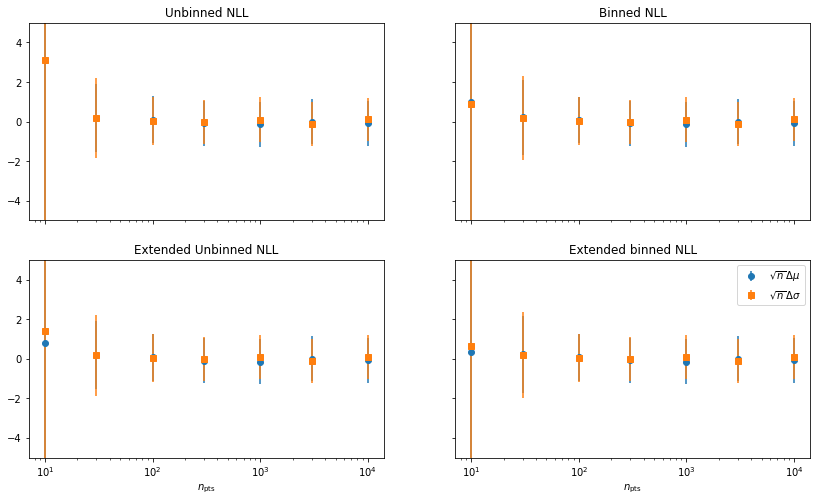

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)

plt.sca(ax[0, 0])
plt.title("Unbinned NLL")
plt.errorbar(n_pts, n_pts ** 0.5 * unbinned_nll[0],
             np.sqrt(n_pts * unbinned_nll[1]),
             fmt="o", label=r"$\sqrt{n}\,\Delta\mu$")
plt.errorbar(n_pts, n_pts ** 0.5 * (unbinned_nll[2] - 1),
             np.sqrt(n_pts * unbinned_nll[3]),
             fmt="s", label=r"$\sqrt{n}\,\Delta\sigma$")

plt.sca(ax[0, 1])
plt.title("Binned NLL")
plt.errorbar(n_pts, n_pts ** 0.5 * binned_nll[0],
             np.sqrt(n_pts * binned_nll[1]),
             fmt="o", label=r"$\sqrt{n}\,\Delta\mu$")
plt.errorbar(n_pts, n_pts ** 0.5 * (binned_nll[2] - 1),
             np.sqrt(n_pts * binned_nll[3]),
             fmt="s", label=r"$\sqrt{n}\,\Delta\sigma$")

plt.sca(ax[1, 0])
plt.title("Extended Unbinned NLL")
plt.errorbar(n_pts, n_pts ** 0.5 * extended_unbinned_nll[2],
             np.sqrt(n_pts * extended_unbinned_nll[3]),
             fmt="o", label=r"$\sqrt{n}\,\Delta\mu$")
plt.errorbar(n_pts, n_pts ** 0.5 * (extended_unbinned_nll[4] - 1),
             np.sqrt(n_pts * extended_unbinned_nll[5]),
             fmt="s", label=r"$\sqrt{n}\,\Delta\sigma$")

plt.sca(ax[1, 1])
plt.title("Extended binned NLL")
plt.errorbar(n_pts, n_pts ** 0.5 * extended_binned_nll[2],
             np.sqrt(n_pts * extended_binned_nll[3]),
             fmt="o", label=r"$\sqrt{n}\,\Delta\mu$")
plt.errorbar(n_pts, n_pts ** 0.5 * (extended_binned_nll[4] - 1),
             np.sqrt(n_pts * extended_binned_nll[5]),
             fmt="s", label=r"$\sqrt{n}\,\Delta\sigma$")

plt.ylim(-5, 5)
plt.legend()
for i in (0, 1):
    ax[1, i].set_xlabel(r"$n_\mathrm{pts}$")
plt.semilogx();